# Diagnosing model performance

- evaluation of model performance to quantify the prediction skill
- model calibration

### State-of-the-art
- elaborate on well-established performance metrics like KGE and NSE (Scheaffli et al. 2007, Knoben et al. 2019)
- quantifying model perfomance

### Added value
- KGE (Gupta et al. 2009, Kling et al. 2012, Pool et al. 2018) and NSE (Nash & Sutcliffe 1970) return numbers between $-\infty$ and 1, but these numbers only provide limited insights into model perfomance
- if my model performance is bad: where do the errors come from? What processes might not be captured by the model?

### Objectives
- Diagnosing model performance by introducing a novel efficiency measure based on flow duration curve
- Flow duration curve covers different processes (e.g. runoff generation, storage recession)

This notebook demonstrates the usage of DE and provides a proof of concept.

## Data
We use observed streamflow data from the river Pfinz, Germany, which is located in the file examples/data/9960682_Q_1970_2012.csv.

In [1]:
import datetime as dt
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy as sp
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})  # controlling figure aesthetics
import de
import warnings
warnings.filterwarnings('ignore')

First, we import a daily observed streamflow time series and plot the time series:

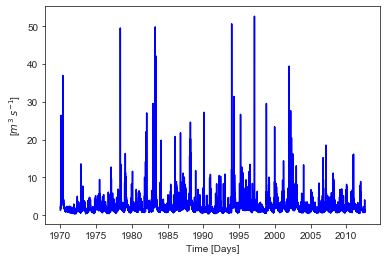

In [2]:
# Import a function that deals with paths properly, regardless of OS
from pathlib import Path  

path = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/data/9960682_Q_1970_2012.csv')
df_ts = de.import_ts(path, sep=';') # import observed time series
de.plot_ts(df_ts)

## Methodology

Here we introduce the novel Diagnostic-Efficiency (DE):

### Diagnostic-Efficieny (DE)
$DE = 1 - \sqrt{B_{Bal}^2 + B_{Slope}^2 + (r - 1)^2}$   (1)

Eqs. (2) - (5) use observed values ($Q_{obs}$) and simulated values ($Q_{sim}$) which are sorted by descending order.

#### Relative Bias ($B_{rel}$)
$B_{rel}(i) = \frac{(Q_{sim}(i) - Q_{obs}(i))}{Q_{obs}(i)}$   (2)

i represents the exceedence probability.

#### Arithmetic mean of relative bias
$B_{bal} = \frac{1}{N}\sum_{i=1}^{N} B_{rel}(i)$   (3)

Value within a range of $-\infty$ to $\infty$ reflects the balance of relative biases. Positive values indicate that the model consistently overestimates (e.g. input surpluses propagate into the model) whereas negative values suggest consistent underestimation by the model (e.g. input shortages propagate into the model). This metric component reflects best errors in the input data.

#### Linear regression for relative bias
$B_{rel}(i) = y + bi$   (4)

#### Slope of linear regression ($B_{Slope}$) derived from Eq. (4)
$B_{slope} = b*100$   (5)

$B_{slope}$ represents inclination of relative biases. The range goes from $-\infty$ to $-\infty$. $b$ is multiplied by 100 to extend over all exceedence probabilities. Positive values indicates that the model underestimate high flows and overstimate low flows (i.e. storages are filled to quickly and release water too slowly). By contrast, negative values describe overestimation of high flows and underestimation of low flows by the model (i.e. storages implemented in the model releas water too quickly). This metric component reflects best errors caused by the model structure/parametrization.

#### Spearmans rank correlation (r) between $Q_{sim}$ and $Q_{obs}$
Equation necessary???    (6)

$r$ represents the rank correlation between $Q_{sim}$ and $Q_{obs}$ which ranges between 1 and -1.

We compare the DE to the widely used Kling-Gupta-Efficiency (KGE) and Nash-Sutcliffe-Efficiency (NSE). 


### Kling-Gupta-Efficiency (KGE)
$KGE = 1 - \sqrt{(\beta - 1)^2 + (\gamma - 1)^2 + (r - 1)^2}$   (7)

where 𝑟 is the rank correlation between observations and simulations, $\gamma$ a measure of the flow variability error, and $\beta$ a bias term:

$KGE = 1 - \sqrt{(\frac{\mu_{sim}}{\mu_{obs}} - 1)^2 + (\frac{CV_{sim}}{CV_{obs}} - 1)^2 + (r - 1)^2}$   (8)

where $\frac{CV_{obs}$ is the coefficient of variation in observations, $\frac{CV_{sim}$ the coefficient of variation in simulations, $\mu_{sim}$ the simulation mean, and ̅̅̅̅̅̅$\mu_{obs}$ the observation mean. 

### Nash-Sutcliffe-Efficiency (NSE)
$NSE = 1 - \frac{\sum_{t=1}^{t=T} (Q_{sim}(t) - Q_{obs}(t))^2}{\sum_{t=1}^{t=T} (Q_{obs}(t) - \overline{Q_{obs}})^2}$    (9)

where $T$ is the total number of time steps, $Q_{sim}(t)$ the simulated discharge at time $t$, $Q_{obs}(t)$ the observed discharge at time $t$. $\overline{Q_{obs}$ the mean observed discharge

### 2-D plots of DE and KGE
Since DE and KGE consists of three components (see Eqs. (1) and (7)), the components can be visulaized in a 2D-space.  The three components biuld up originally a 3D-space, but can be reduced to a 2D-space by representing the temporal component (r) assigning a color. In the following we show two examples for the cases $DE = 1$ and $KGE = 1$.

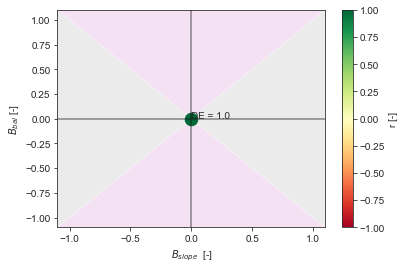

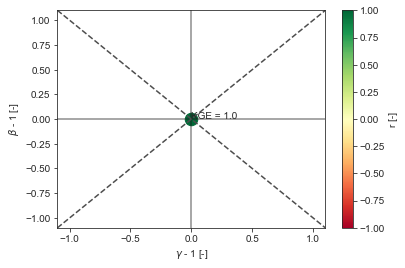

In [3]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = df_ts.loc[:, 'Qobs']  # observed time series

# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

The upper figure shows the visualitazion of the DE in the 2D-space. We call it the hydrologic modeling clock. The shorter the lenght of the hand and the greener the error the better is the model performance. By contrast, the longer the hand the worse performs the model. The shaded regions are used to identify where the error comes from. Regions are colorized purple if $B_{bal}$ is greater than $B_{slope}$. Thus, the origin of errors comes from input data. For greyish regions, $B_{bal}$ is less than $B_{slope}$ which means that the origin of errors is linked to the model itself.

For comparison, we display the KGE in the 2D-space. In contrast to the DE, the 2D-plot does not allow to distinguish between the origin of errors.

## Proof of concept
In order to mimick model errors or input data errors, respectively, we manipulate the observed time series:
1. Mimicking model errors
2. Mimicking input data errors
3. Mimicking temporal mismatch
4. Combination of 1., 2., and 3.
5. Mean flow benchmark

### 1. Mimicking model errors

#### Increase high flows - Decrease low flows

We generate a new by time series by increasing high flows and decreasing low flows. In particular we tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in steeper gradient of the flow duration curve (see the upper figure below; red curve).

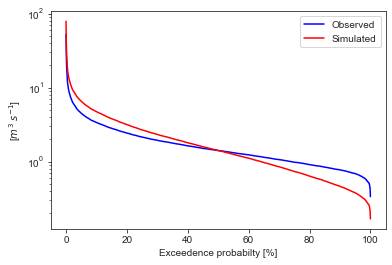

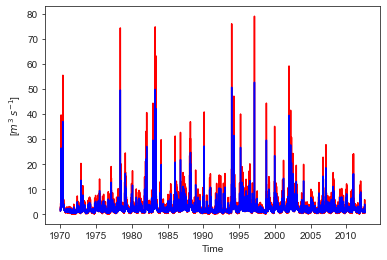

In [4]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # disaggregated time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

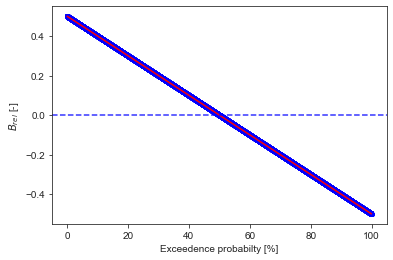

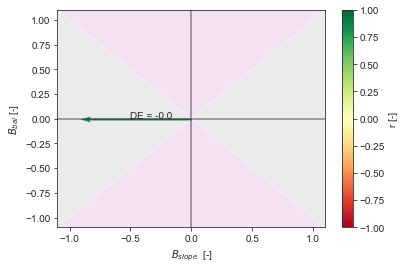

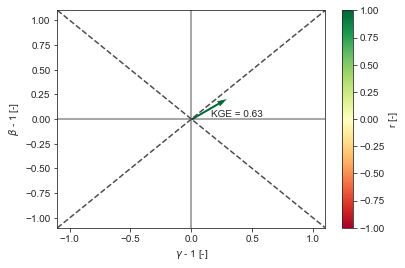

In [5]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [6]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.0
KGE: 0.63
NSE: 0.65


The upper figure shows the result for the linear regression for relativa Biases.

The figure in the middle represents the visualisation of the DE in the 2D-space which gives evidence that the model structure/parameterisation is deficient resulting in a DE which is 0.

The lower figure represents the KGE in a 2D-space.

#### Decrease high flows - Increase low flows

We generate a new by time series by decreasing high flows and increasing low flows. We tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in a flatter gradient of the flow duration curve (see the upper figure below; red curve).

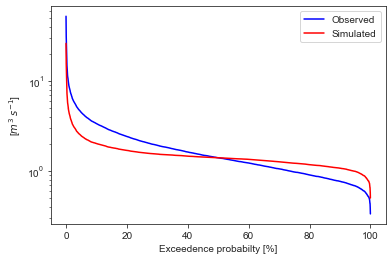

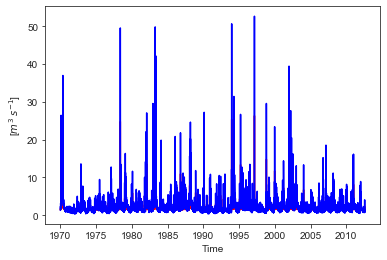

In [7]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # smoothed time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

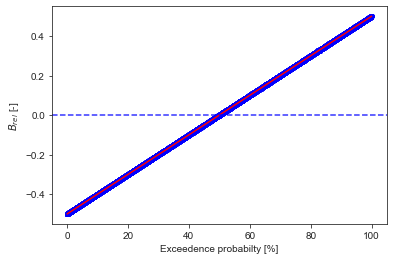

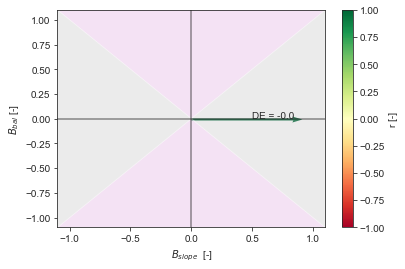

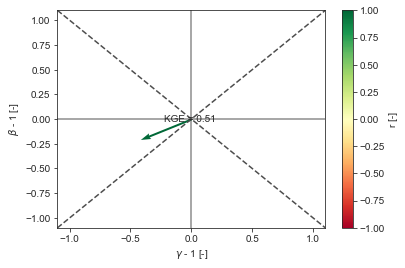

In [8]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [9]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.0
KGE: 0.51
NSE: 0.65


### 2. Mimicking input data errors

#### Precipitation surplus
Precipitation surplus is imitated by multplying the time series with a constant offset of 1.5 (see the upper figure below; red curve). Generally, the offset has to be greater than 1.

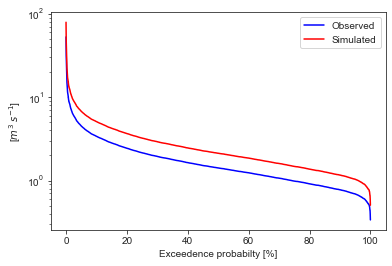

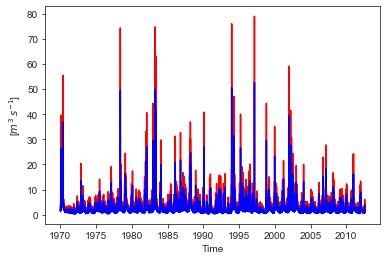

In [10]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(df_ts['Qobs'].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

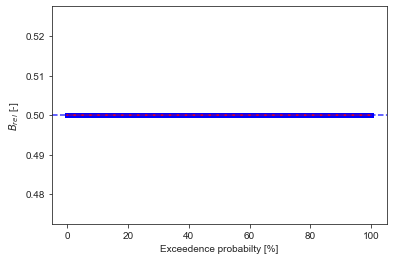

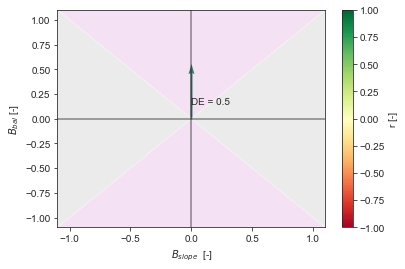

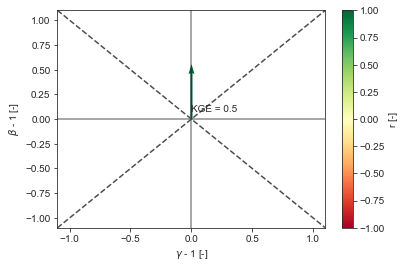

In [11]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

#### Precipitation shortage
Precipitation shortage is imitated by multplying the time series with a constant offset of 0.5 (see the upper figure below; red curve). Generally, the offset has to be less than 1.

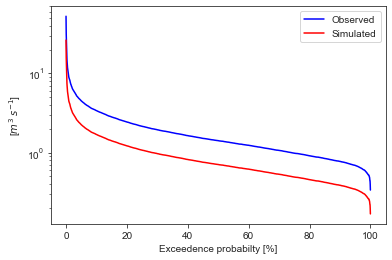

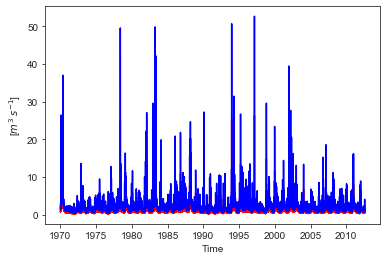

In [12]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(df_ts['Qobs'].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

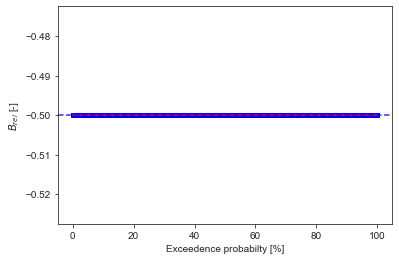

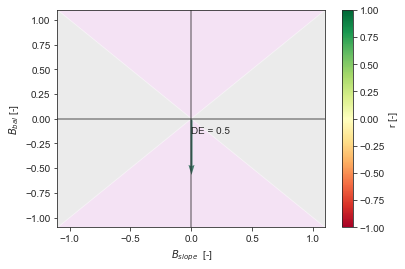

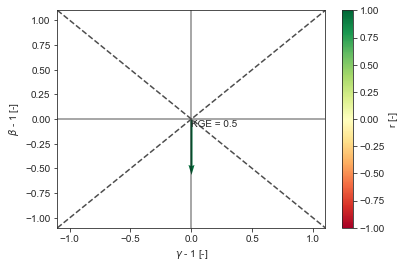

In [13]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

### Mimicking temporal mismatch

#### Shuffling 

We shuffle the time series.

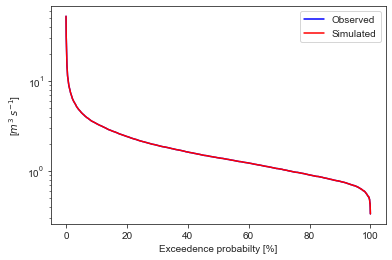

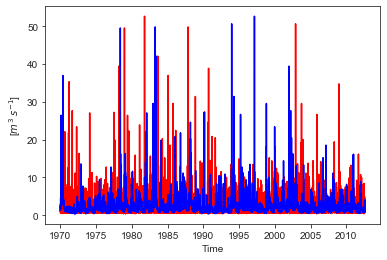

In [14]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tss = de.time_shift(df_ts.copy(), random=True)  # shuffled time series
obs_sim.loc[:, 'Qsim'] = tss.iloc[:, 0].values
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

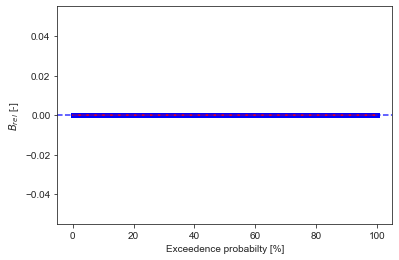

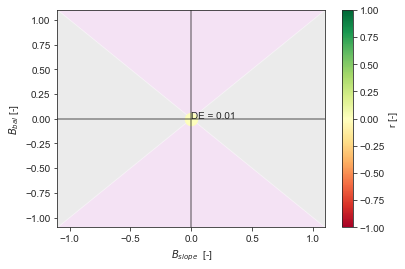

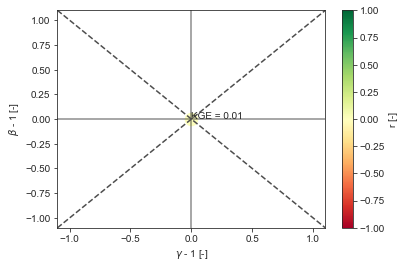

In [15]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [16]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.01
KGE: 0.01
NSE: -1.01


### Combination of 1., 2., and 3.

#### Decrease high flows - Increase low flows and precipitation surplus
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5.

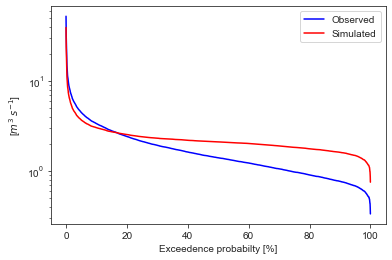

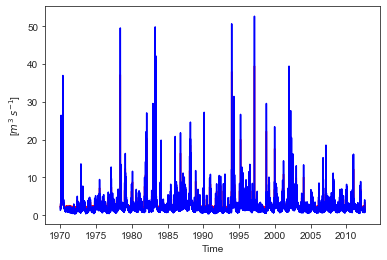

In [17]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(tsd.iloc[:, 0].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

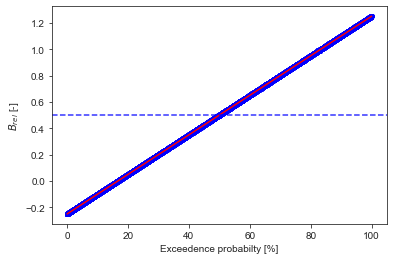

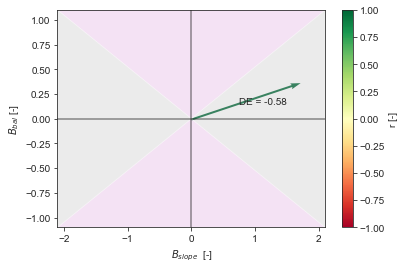

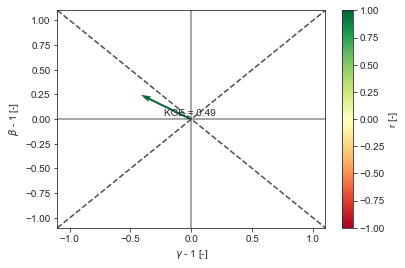

In [18]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [19]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.58
KGE: 0.49
NSE: 0.83


#### Decrease high flows - Increase low flows and precipitation shortage
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 0.5.

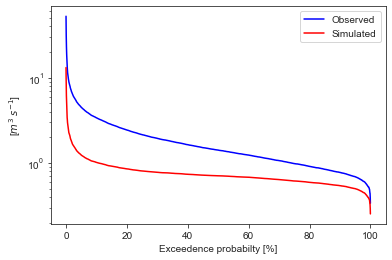

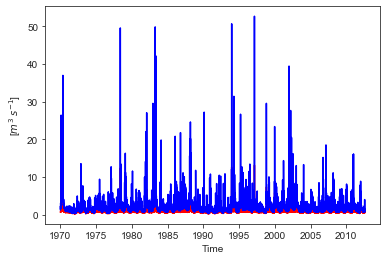

In [20]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(tsd.iloc[:, 0].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

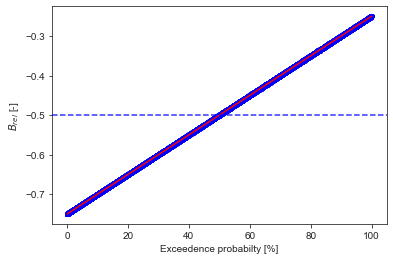

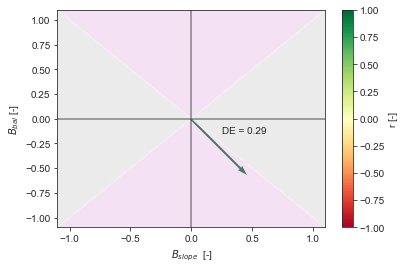

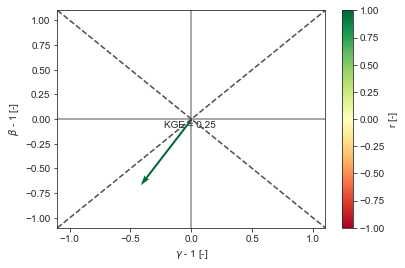

In [21]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [22]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.29
KGE: 0.25
NSE: 0.08


#### Increase high flows - Decrease low flows and precipitation surplus
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by increasing high flows and decreasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5.

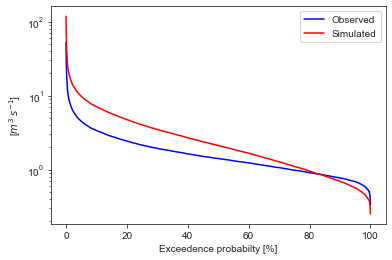

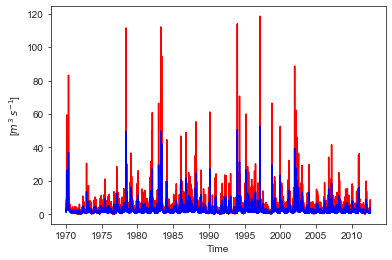

In [23]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)  # disaggregated time series
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(tsd.iloc[:, 0].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

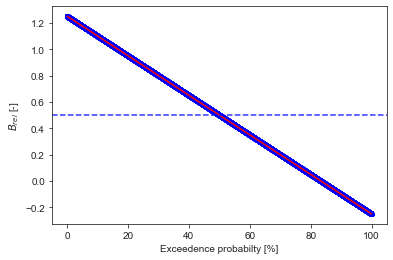

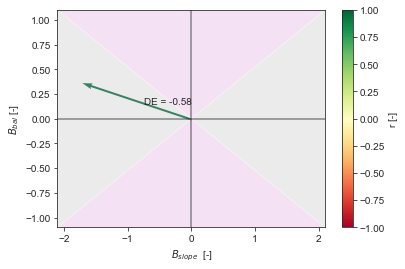

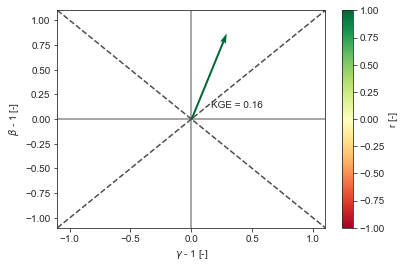

In [24]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [25]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.58
KGE: 0.16
NSE: -1.34


#### Increase high flows - Decrease low flows and precipitation shortage
First, we tilt the flow duration curve around its median (i.e. $Q_{50}$) by increasing high flows and decreasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 0.5.

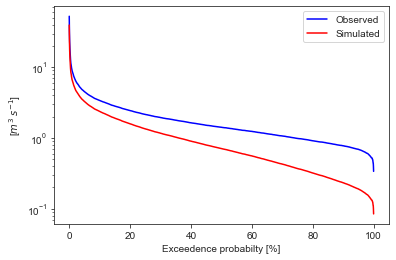

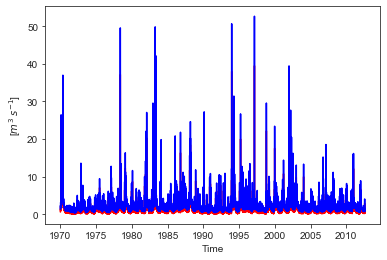

In [26]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5) # disaggregated time series
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(tsd.iloc[:, 0].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

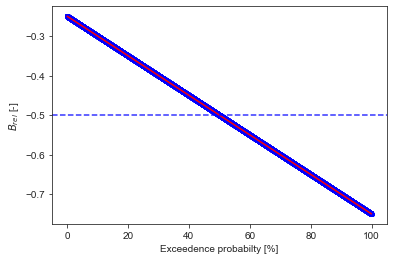

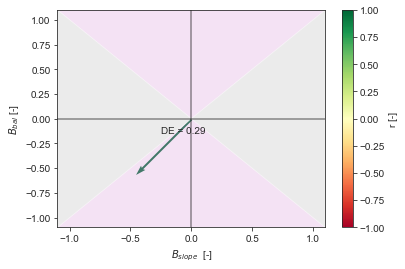

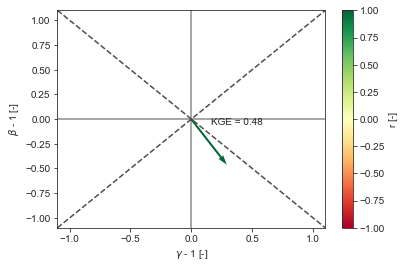

In [27]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [28]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.29
KGE: 0.48
NSE: 0.8


#### Decrease high flows - Increase low flows,  precipitation surplus and shuffling

First, we tilt the flow duration curve around its median (i.e. 𝑄50) by decreasing high flows and increasing low flows. Subsequently, we multiply the already manipulated time series by multiplying a constant positive offset of 1.5 and finally we shift the time series 3 days forward.

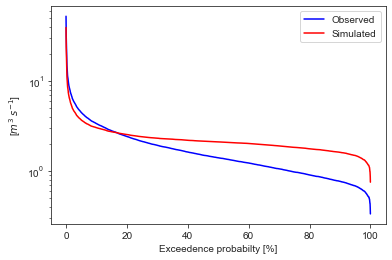

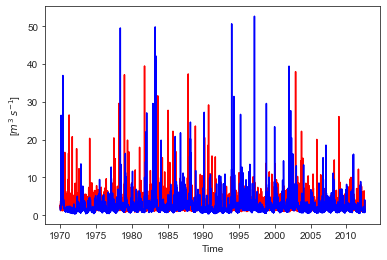

In [29]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
tsp = pd.DataFrame(index=df_ts.index, columns=['Qsim'])
tsp.iloc[:, 0] = de.pos_shift_ts(tsd.iloc[:, 0].values)  # positive offset
tst = de.time_shift(tsp, random=True)  # shuffling
obs_sim.loc[:, 'Qsim'] = tst.iloc[:, 0].values
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

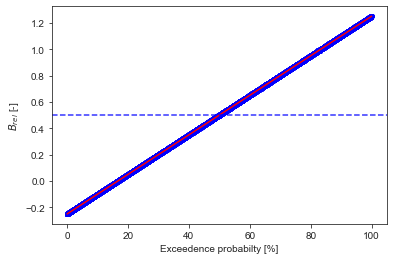

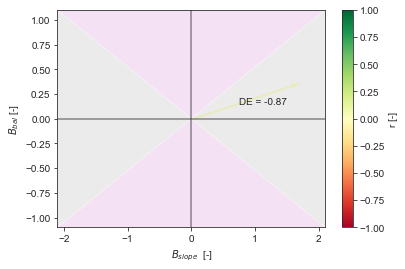

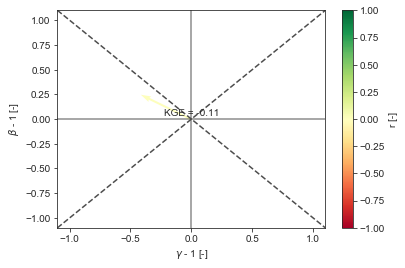

In [30]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [31]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.87
KGE: -0.11
NSE: -0.49


### Mean flow benchmark
Here, we adapt the mean flow benchmark from Knoben et al. (2019).

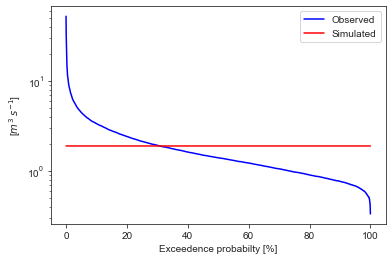

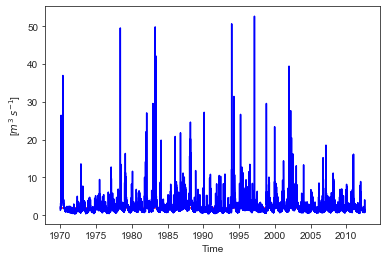

In [32]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_mean = np.mean(obs_sim['Qobs'].values)
obs_sim.loc[:, 'Qsim'] = np.repeat(obs_mean, len(obs_sim['Qobs'].values))
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. The upper figure shows the linear regression for the relative bias. Dashed line displays arithmetic mean of the relative bias. The two figures at the bottom show DE and KGE plotted in a 2D-space.

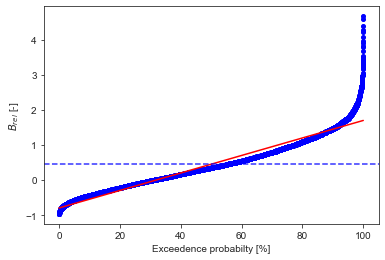

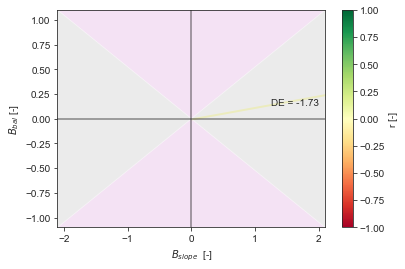

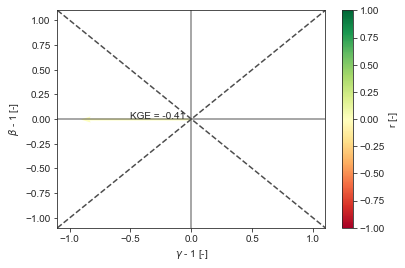

In [33]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # manipulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [34]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -1.73
KGE: -0.41
NSE: 0.0


The mean average flow benchmark of DE is -1.73. Compared to the KGE and NSE benchmark it is substantially lower meaning that...

###  Real case example (eartH2Observe Tier-2)
In order to prove the applicability of DE, we applied for a real case. For this purpose, we used simulated runoff from the eartH2Observe Tier-2 dataset for the catchment with the ID 4103631 (Global Runoff Data Center).

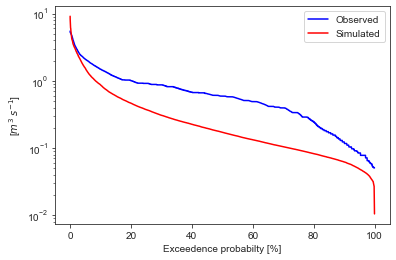

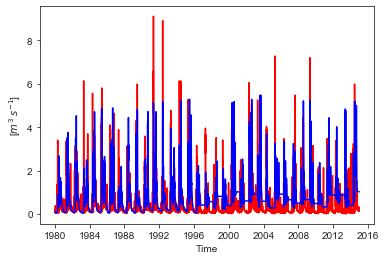

In [35]:
path_wrr2 = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/data/GRDC_4103631_wrr2.csv')
df_wrr2 = de.import_ts(path_wrr2, sep=';') # import time series
de.fdc_obs_sim(df_wrr2['Qobs'], df_wrr2['Qsim'])
de.plot_obs_sim(df_wrr2['Qobs'], df_wrr2['Qsim'])

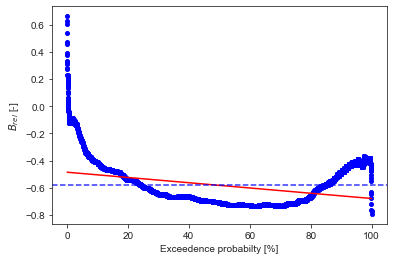

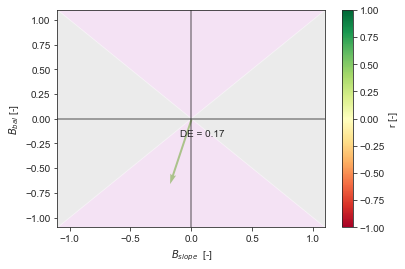

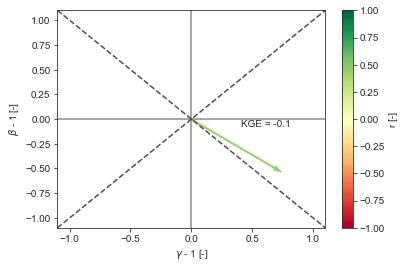

In [36]:
# make numpy arrays
obs_arr = df_wrr2['Qobs'].values  # observed time series
sim_arr = df_wrr2['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [37]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.17
KGE: -0.1
NSE: -0.48


The results reveal a weak model performance. Errors have its origin rather in the input data (i.e. precipitation shortage) than in the model structure/parameterization. Compared to the 2D-plot of KGE, such pattern remains invisible.

## Limitations
- accuracy of linear regression to determine $B_{slope}$
- works only for perennial rivers? Too many zero values for ephermal/episodic rivers. Affects calculation relative bias (Fowler et al. 2018)
- ...

## Conclusions
- tool for diagnostic model evaluation
- identfying orgin of errors visualizing the three components in a 2D-space
- Comparison to KGE and NSE
- mean flow benchmark of DE
- advancing model development

## References

Fowler, K., Peel, M., Western, A., and Zhang, L.: Improved Rainfall-Runoff Calibration for Drying Climate: Choice of Objective Function, Water Resources Research, 54, 3392-3408, 10.1029/2017wr022466, 2018.

Gupta, H. V., Kling, H., Yilmaz, K. K., and Martinez, G. F.: Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modelling, Journal of Hydrology, 377, 80-91, 10.1016/j.jhydrol.2009.08.003, 2009.

Kling, H., Fuchs, M., and Paulin, M.: Runoff conditions in the upper Danube basin under an ensemble of climate change scenarios, Journal of Hydrology, 424-425, 264-277, 10.1016/j.jhydrol.2012.01.011, 2012.

Knoben, W. J. M., Freer, J. E., and Woods, R. A.: Technical note: Inherent benchmark or not? Comparing Nash-Sutcliffe and Kling-Gupta efficiency scores, Hydrol. Earth Syst. Sci. Discuss., 2019, 1-7, 10.5194/hess-2019-327, 2019.

Nash, J. E., and Sutcliffe, J. V.: River flow forecasting through conceptual models part I - A discussion of principles, Journal of Hydrology, 10, 282-290, 10.1016/0022-1694(70)90255-6, 1970.

Pool, S., Vis, M., and Seibert, J.: Evaluating model performance: towards a non-parametric variant of the Kling-Gupta efficiency, Hydrological Sciences Journal, 63, 1941-1953, 10.1080/02626667.2018.1552002, 2018.

Schaefli, B., and Gupta, H. V.: Do Nash values have value?, Hydrological Processes, 21, 2075-2080, 10.1002/hyp.6825, 2007.